# Tentativa de análise estatística inferencial de dados econômicos do Brasil

### Info:
- https://www.ibge.gov.br/explica/inflacao.php 

### Dados analizados:
- https://sidra.ibge.gov.br/tabela/1737
- https://dados.gov.br/dataset/dolar-americano-usd-todos-os-boletins-diarios
- https://www.eia.gov/dnav/pet/hist/rbrteM.htm
- https://stats.oecd.org/Index.aspx?DataSetCode=PRICES_CPI#

In [2]:
# importação das bibliotecas principais
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

path = 'dados'
filename = {
    'ipca mensal':'IPCA - Variação mensal', 
    'ipca acumulado':'IPCA - Variação acumulada em 12 meses', 
    'dolar':'Cotação do Dólar', 
    'oil':'RBRTEm',
    'cpi':'PRICES_CPI'
}

Para facilitar a análise será implementado algumas funções, sendo elas:
- Coeficiente de correlação linear:
\\[corrccoef\_linear(x, y) = \dfrac{n\sum{xy} - (\sum{x})(\sum{y})}{\sqrt{n\sum{x^2} - (\sum{x})^2}\sqrt{n\sum{y^2} - (\sum{y})^2}} \\]
- Método dos mínimos quadrados (MMQ):
\\[Y = mX + b\\]
\\[m = \dfrac{\sum{(x - \bar{x})(y - \bar{y})}}{\sum{(x - \bar{x})^2}}\\]
\\[b = \bar{Y} - m\bar{X}\\]

In [63]:
def nrange(xi, xf=None, dx=1):
    '''
    Contagem com intervalo aberto.
    
    Args:
        xi: float; Valor inicial.
        xf: float; Valor final.
        dx: foat; Intervalo.
    '''
    if not xf: xf = xi; xi = 0
    while xi <= xf:
        yield xi
        xi += dx
    
def get(var_list, indexes, array=False):
    var = []
    for i in indexes:
        try: u = var_list[i]
        except IndexError: u = np.nan
        var.append(u)
    return np.array(var) if array else var

def corrcoef_linear(X, Y):
    n = len(X)
    return (n*np.nansum(X*Y) - np.nansum(X)*np.nansum(Y))/((n*np.nansum(X**2) - np.nansum(X)**2)**0.5 * (n*np.nansum(Y**2) - np.nansum(Y)**2)**0.5)

def MMQ(X, Y, angular=False):
    m = np.nansum((X - np.nanmean(X))*(Y - np.nanmean(Y)))/np.nansum((X - np.nanmean(X))**2)
    b = np.nanmean(Y) - m*np.nanmean(X)
    f = lambda x: m*x + b
    return [f, m] if angular else f

def moving_average(x, w):
    wi = int(w/2)
    wf = wi+1
    u = []
    for i in range(len(x)):
        values = x[i-wi:i+wf]
        if len(values):
            if len(values) < w: w = len(values)
            u.append(np.sum(values)/w)
        else: u.append(0)
    return u

## 1.0 Importação dos dados

#### Para facilitar a análise os dados serão armazenados no formato de vetor (numpy array).
 - A variável `month` armazena as datas para ter referência.

 ### 1.1 Importação dos dados do IPCA

In [4]:
ipca_mensal = pd.read_csv(os.path.join(path, filename['ipca mensal'])+'.csv').to_numpy().T[1]
month, ipca_acum = pd.read_csv(os.path.join(path, filename['ipca acumulado'])+'.csv').to_numpy().T
month = list(month)
pd.read_csv(os.path.join(path, filename['ipca acumulado'])+'.csv')

,mês,valor
0,01-1980,NaN
1,02-1980,NaN
2,03-1980,NaN
3,04-1980,NaN
4,05-1980,NaN
...,...,...
494,03-2021,6.10
495,04-2021,6.76
496,05-2021,8.06
497,06-2021,8.35


### 1.2 Importação dos dados sobre o dólar

In [5]:
df1 = pd.read_csv(os.path.join(path, filename['dolar'])+'.csv')
df1.head()

,compra,venda,data
0,2814.0,2828.0,03-12-1984
1,2814.0,2828.0,03-12-1984
2,2867.0,2881.0,04-12-1984
3,2867.0,2881.0,05-12-1984
4,2867.0,2881.0,05-12-1984


- **Analisando os dos valores da cotação, temos:**

Média: -1.1480041256498195
Média da diferença absoluta: 1.1496247428381834
Mediana: -0.0007999999999999119
Variância: 41.21736763009359
Desvio padrão: 6.420075360156888


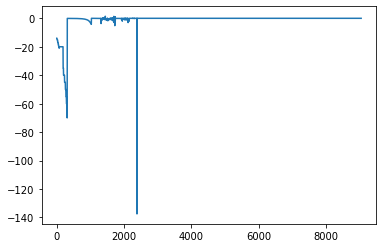

In [6]:
difcot = df1['compra'] - df1['venda'] # diferença entre a cotação de compra e cotação de venda
print('Média:', np.mean(difcot))
print('Média da diferença absoluta:', np.mean(abs(difcot)))
print('Mediana:', np.median(difcot))
print('Variância:', np.var(difcot))
print('Desvio padrão:', np.std(difcot))
plt.plot(difcot)
plt.show()

Pode-se observar que os valores, no geral, tem pouca variação. Logo, para a análise, será tomado a média dos valores em torno da data. Para relacionar os dados será tomado a média mensal da cotação.

In [7]:
%%time
f_mstf = lambda x: '-'.join(x.split('-')[1:])
month_cot = [f_mstf(m) for m in df1['data']]
cot_dolar = []
for M in month:
    val = []
    for i, m in enumerate(month_cot):
        if m == M: val.append((df1.iloc[i]['compra'] + df1.iloc[i]['venda'])/2)
    cot_dolar.append(np.nan if not len(val) else np.mean(val))
cot_dolar = np.array(cot_dolar)

Wall time: 12.6 s


### 1.3 Importação dos dados sobre o preço do barril de petróleo

In [8]:
df2 = pd.read_csv(os.path.join(path, filename['oil'])+'.csv')
oil_price = []
for M in month:
    value = df2.loc[df2['date'] == M]
    oil_price.append(value.iloc[0]['brent spot price'] if len(value) else np.nan)
oil_price = np.array(oil_price)
df2.head()

,date,brent spot price
0,05-1987,18.58
1,06-1987,18.86
2,07-1987,19.86
3,08-1987,18.98
4,09-1987,18.31


In [10]:
prices_cpi = pd.read_csv(os.path.join(path, filename['cpi'])+'.csv').drop(columns='Date')
prices_cpi.head()

,Luxembourg,OECD - Europe,Brazil,G20,Slovak Republic,Turkey,Canada,Latvia,Slovenia,Germany,...,Italy,Ireland,Lithuania,South Africa,France,Switzerland,China (People's Republic of),Israel,Sweden,Japan
0,3.214605,5.878082,8.853113,4.459063,13.61772,68.87825,2.185792,3.089545,7.781360,1.549464,...,2.203857,4.017217,0.852384,2.648305,1.539053,1.585403,-0.2,1.216216,0.448046,-0.9
1,2.669265,5.993550,7.862087,4.633076,16.42276,69.74646,2.729258,3.468712,8.422837,1.547619,...,2.383135,4.279601,0.814968,2.330508,1.355325,1.623698,0.7,1.632653,0.931229,-0.6
2,2.812105,5.917166,6.923308,4.676515,16.54501,67.89619,3.043478,3.242113,9.034197,1.547619,...,2.470265,4.694168,0.828476,3.389831,1.491016,1.482930,-0.2,1.500682,1.032529,-0.5
3,2.711602,5.545000,6.774717,4.280593,15.98063,63.82483,2.162162,3.752836,9.242109,1.066351,...,2.281022,4.809052,0.783294,4.545455,1.207269,1.402478,-0.3,1.768708,0.720400,-0.8
4,2.549493,5.572327,6.465620,4.277447,16.02254,62.67466,2.373247,3.076121,9.037951,0.947867,...,2.459016,5.211267,0.451928,5.079365,1.397713,1.580529,0.1,1.894452,1.008969,-0.7


### 1.4 Plotagem dos dados 

In [11]:
def month_range(month_i=None, month_f=None, step=1):
    '''
    Pegar índices a partir da data.
    
    Args:
        month_i: string; data inicial.
        month_f: string; data final.
        step: int; período de diferença entre os meses.
    
    Return: list[ list[x], list[xt] ], onde 'x' são os índices e 'xt' as respectivas datas.
    '''
    if not month_i: month_f = month[-1]; month_i = month[0]
    elif not month_f: month_f = month_i; month_f = month[-1]
    x, xt = [], []
    for t in nrange(month.index(month_i), month.index(month_f), step):
        x.append(t)
        xt.append(month[t])
    return x, xt

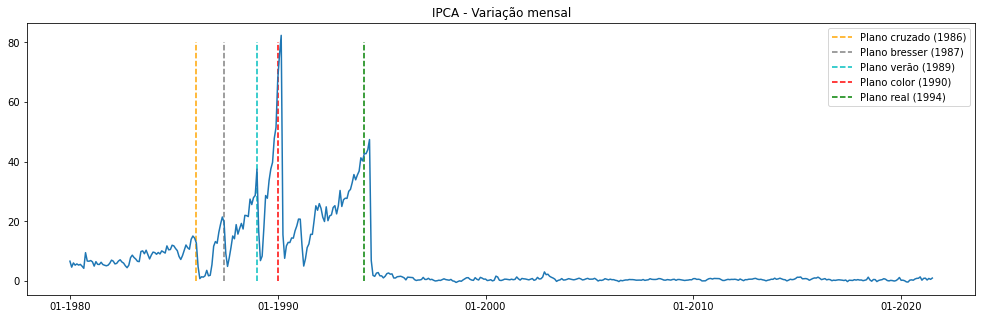

In [12]:
plt.figure(figsize=(17, 5))
plt.title('IPCA - Variação mensal')
plt.vlines(month.index('02-1986'), 0, 80, color='orange', linestyles='dashed', label='Plano cruzado (1986)')
plt.vlines(month.index('06-1987'), 0, 80, color='gray', linestyles='dashed', label='Plano bresser (1987)')
plt.vlines(month.index('01-1989'), 0, 80, color='c', linestyles='dashed', label='Plano verão (1989)')
plt.vlines(month.index('01-1990'), 0, 80, color='r', linestyles='dashed', label='Plano color (1990)')
plt.vlines(month.index('03-1994'), 0, 80, color='g', linestyles='dashed', label='Plano real (1994)')
plt.plot(ipca_mensal)
plt.xticks(*month_range(step=120))
plt.legend()
plt.show()

No gráfico acima tem-se uma visão geral da inflação no Brasil e a chamada [Hiperinflação](https://pt.wikipedia.org/wiki/Hiperinfla%C3%A7%C3%A3o_no_Brasil)

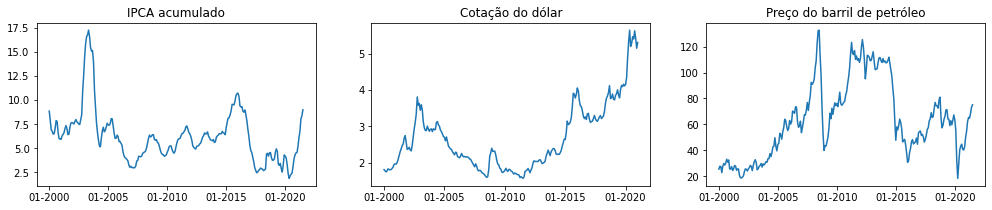

In [13]:
fis, axs = plt.subplots(1, 3, figsize=(17, 3))
x, xt = month_range('01-2000', step=12*5)

axs[0].plot(range(x[0], len(month)), ipca_acum[x[0]:])
axs[0].title.set_text('IPCA acumulado')
axs[0].set_xticks(x, minor=False)
axs[0].set_xticklabels(xt, minor=False)

axs[1].plot(range(x[0], len(month)), cot_dolar[x[0]:])
axs[1].title.set_text('Cotação do dólar')
axs[1].set_xticks(x, minor=False)
axs[1].set_xticklabels(xt, minor=False)

axs[2].plot(range(x[0], len(month)), oil_price[x[0]:])
axs[2].title.set_text('Preço do barril de petróleo')
axs[2].set_xticks(x, minor=False)
axs[2].set_xticklabels(xt, minor=False)

plt.show()

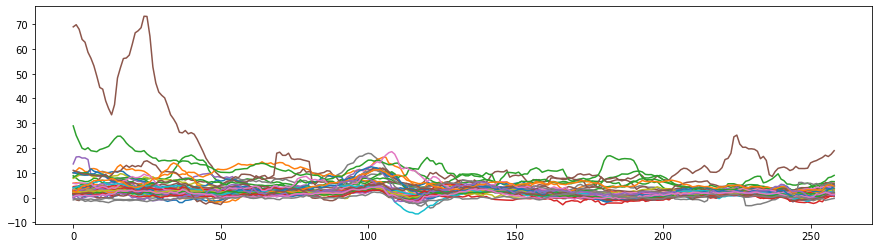

In [16]:
plt.figure(figsize=(15,4))
for country in prices_cpi.columns.values:
    plt.plot(prices_cpi[country])
plt.show()

## 2.0 Análise geral

### 2.1 Correlação entre variáveis

Para tentar elaborar modelos para a inflação é preciso encontrar variáveis que estejam relacionados com a variação dos preços no Brasil. A variáveis analisadas são:
- Passagem do tempo;
- Cotação do dólar;
- Preço do barril de petróleo.

Se for verificado alguma relação entre tais variáveis será possivel explicá-la matematicamente.

O gráfico abaixo mostra o valor *relativo* de cada variável.

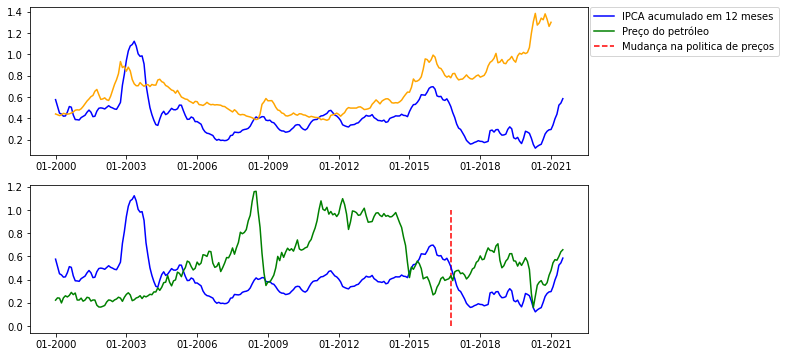

In [18]:
fig, axs = plt.subplots(2, figsize=(10, 6))
x, xt = month_range('01-2000', step=12*3)
ri = range(x[0], len(month))

rel = lambda val: val/(np.nanmax(val)-np.nanmin(val))

dados = [
    ['IPCA acumulado em 12 meses', rel(ipca_acum[x[0]:]), 'b'],
    ['Cotação do dólar', rel(cot_dolar[x[0]:]), 'orange'],
    ['Preço do petróleo', rel(oil_price[x[0]:]), 'g']
]

for label, data, color in dados[:2]:
    axs[0].plot(ri, data, label=label, c=color)
axs[0].set_xticks(x, minor=False)
axs[0].set_xticklabels(xt, minor=False)

for label, data, color in [dados[0], dados[2]]:
    axs[1].plot(ri, data, label=label, c=color)
axs[1].vlines(month.index('10-2016'), 0, 1, color='r', linestyles='dashed', label='Mudança na politica de preços')
axs[1].set_xticks(x, minor=False)
axs[1].set_xticklabels(xt, minor=False)

plt.legend(bbox_to_anchor=(1.35, 2.23))

plt.show()

Sobre o gráfico podemos resaltar alguns pontos:
- A partir de outubro de 2016 a política de preços da Pretrobras foi alterada e passou a ser ditada pelo preço do barril de petróleo no mercado internacional. Por isso, pode-se observar que a variação dos preços está fortimente ao barril do petróleo.

Agora podemos observar o digrama de disperção para cada variável:

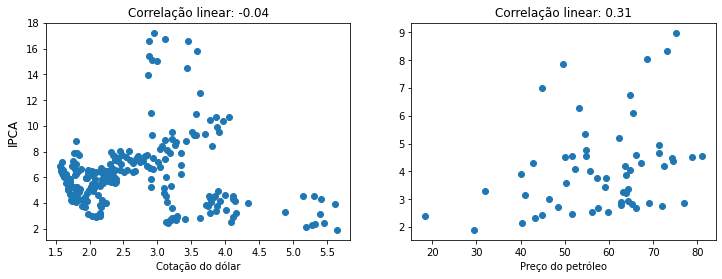

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

t = month_range('01-2000', step=12*2)[0]
x, y = cot_dolar[t[0]:], ipca_acum[t[0]:]
axs[0].title.set_text(f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[0].scatter(x, y)
axs[0].set_xlabel('Cotação do dólar')

t = month_range('10-2016', step=12*2)[0]
x, y = oil_price[t[0]:], ipca_acum[t[0]:]
axs[1].title.set_text(f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[1].scatter(x, y)
axs[1].set_xlabel('Preço do petróleo')

fig.supylabel('IPCA', x=0.08)
plt.show()

*Observação: quanto aos preços do petróleo, foram plotados os dados a partir de outubro de 2016, que foi quando o valor do petróleo no mercado internacional começou a influemciar os preços dos produtos no Brasil através da petrobras.*

Como podemos perceber, a correlação linear para as variáveis é bem fraca. Uma explicação para isso seria que os dados plotados correspondem aos valores a partir de janeiro de 2000, o que não cabe no problema já que o foco é encontrar uma relação para a **inflação**. Portanto, podemos encontrar períodos que caracterizam uma inflação. Para isso, o algoritmo a seguir irá varificar períodos em que os valores so IPCA são crescentes ao longo de 6 meses e tem variação maior ou igual à 4%, para reduzir o ruído será tomado a média móvel em 12 meses.

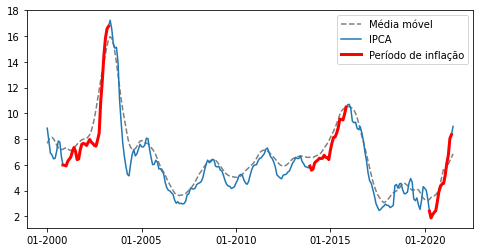

In [76]:
t = month_range('01-2000')[0]
av_ipca = moving_average(ipca_acum, 12)

infl = []
infl_add = []
for i in range(t[0], len(av_ipca)):
    if av_ipca[i-1] <= av_ipca[i]: infl_add.append(i)
    elif len(infl_add):
        infl.append(infl_add.copy())
        infl_add.clear()
infl.append(infl_add.copy())

cont = True
while cont:
    cont = False
    for i in range(len(infl)-1):
        if infl[i+1][0] - infl[i][-1] < 6: 
            infl[i] += infl[i+1]
            infl.pop(i+1)
            cont = True
            break

infl = [np.arange(val[0], val[-1]) for val in infl if len(val) > 6 and np.max(ipca_acum[val[0]:val[-1]]) - np.min(ipca_acum[val[0]:val[-1]]) > 4]

plt.figure(figsize=(8,4))
plt.plot(t, av_ipca[t[0]:], '--', c='gray', label='Média móvel')
plt.plot(t, ipca_acum[t[0]:], label='IPCA')
lines = [plt.plot(var, get(ipca_acum, var), '-', c='r', linewidth=3)[0] for var in infl]
lines[0].set_label('Período de inflação')
plt.xticks(*month_range('01-2000', step=60))
plt.legend()
plt.show()

Agora, já com os períodos inflacionários, podemos comparar as variáveis durante tais períodos. Começando pela cotação do dólar:

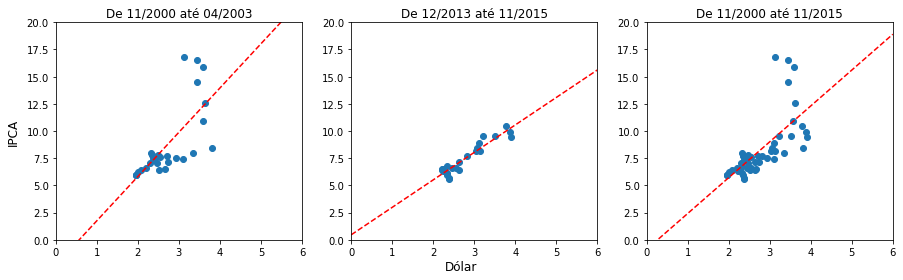

,Período,Correlção linear,Coeficiente angular
0,De 11/2000 até 04/2003,71.74%,4.070301
1,De 12/2013 até 11/2015,94.47%,2.527186
2,De 11/2000 até 11/2015,69.94%,3.297854


In [77]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

rs = []
rows = []
ang_coefs = []
models = []
for i, Y in enumerate(list(infl[:-1]) + [list(infl[0]) + list(infl[1])]):
    title = f'De {month[Y[0]]} até {month[Y[-1]]}'.replace('-', '/')
    X = np.array(get(cot_dolar, Y))
    Y = np.array(get(ipca_acum, Y))
    
    f, m = MMQ(X, Y, angular=True)
    models.append(f)
    ang_coefs.append(m)
    rs.append(f'{corrcoef_linear(X, Y)*100:.2f}%')
    rows.append(title)
    
    axs[i].set_xlim(0, 6)
    axs[i].set_ylim(0, 20)
    axs[i].title.set_text(title)
    axs[i].scatter(X, Y)
    X = np.linspace(0, 6, 100)
    axs[i].plot(X, f(X), '--', c='r')
    
fig.supxlabel('Dólar')
fig.supylabel('IPCA', x=0.08)
plt.show()
pd.DataFrame({'Período':rows, 'Correlção linear':rs, 'Coeficiente angular':ang_coefs}).head()

Quanto ao valor do petróleo só poderão ser análisados os valores do período inflacionário de 2020. Portanto, foi encontrado o valor de 89% de correlação linear. Abaixo mostra o gráfico de disperção já com o modelo de regressão linear (MMQ).

Correlação linear: 89.00%


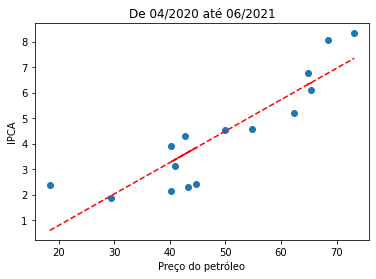

In [54]:
Y = infl[-1]
plt.title(f'De {month[Y[0]]} até {month[Y[-1]]}'.replace('-', '/'))
X = np.array(get(oil_price, Y))
Y = np.array(get(ipca_acum, Y))
print(f'Correlação linear: {corrcoef_linear(np.array(X), np.array(Y))*100:.2f}%')

f = MMQ(X, Y)

plt.scatter(X, Y)
plt.plot(X, f(X), '--', c='r')
plt.xlabel('Preço do petróleo')
plt.ylabel('IPCA')
plt.show()

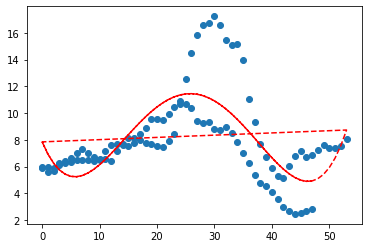

In [55]:
T = []
U = []
for i in range(len(infl)-1):
    xdas = np.concatenate([infl[i], range(infl[i][-1]+1, infl[i][-1]+25)])
    T.append(np.arange(len(xdas)))
    U.append(get(ipca_acum, xdas))

X = np.concatenate(T)
Y = np.concatenate(U)

modeloPoly = np.poly1d(np.polyfit(X, Y, 4))

plt.scatter(X, Y)
plt.plot(X, modeloPoly(X), '--', c='r')
plt.show()

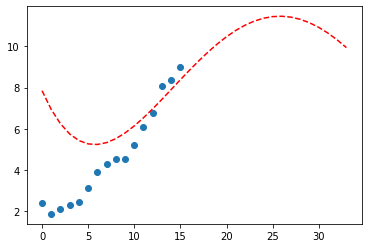

In [75]:
xdas =  np.concatenate([infl[-1], range(infl[-1][-1]+1, infl[-1][-1]+20)])
X = np.arange(len(xdas))
Y = []
for t in xdas:
    try: Y.append(ipca_acum[t])
    except IndexError: Y.append(np.nan)

plt.scatter(X, Y)
plt.plot(modeloPoly(X), '--', c='r')
plt.show()

Para melhorar a modelagem do modelo será coletado dados do índice de preços ao consumidor de vários países.

In [101]:
%%time
t = np.arange(len(month_range('01-2000')[0]))

points = []
for country in prices_cpi.columns.values:
    data_o = prices_cpi[country].values
    data = moving_average(data_o, 12)

    infl = []
    infl_add = []
    for i in range(t[0]+1, len(data)):
        if data[i-1] <= data[i]: infl_add.append(i)
        elif len(infl_add):
            infl.append(infl_add.copy())
            infl_add.clear()
    if len(infl_add): infl.append(infl_add.copy())

    cont = True
    while cont:
        cont = False
        for i in range(len(infl)-1):
            if infl[i+1][0] - infl[i][-1] < 6: 
                infl[i] += infl[i+1]
                infl.pop(i+1)
                cont = True
                break

    for val in infl:
        
        if len(val) > 6:
            dy = np.max(data_o[val[0]:val[-1]]) - np.min(data_o[val[0]:val[-1]])
            if 20 > dy > 4:
                u = 0 if val[-1] + 12 >= len(data_o) else 12
                xdas = np.arange(val[0], val[-1]+u)
                points.append(np.stack([np.arange(val[-1] - val[0] + u), get(data_o, xdas, True)], axis=1))
            
points = np.concatenate(points)
len(points)

Wall time: 618 ms


2648

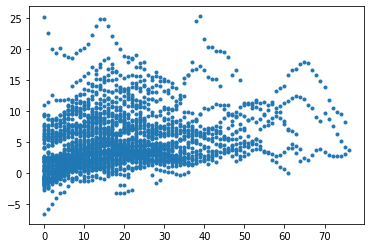

In [102]:
plt.scatter(*np.array(points).T, marker='.')
plt.show()